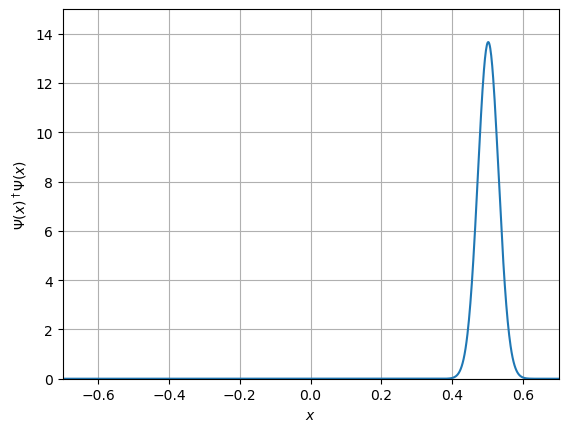

In [29]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from numpy.linalg import multi_dot
# from IPython.display import HTML

# Define the (smooth) step potential
# V(x)=0.5*V0*(tanh(x/w)+1)
def V(x, V0, w):
    return V0*0.5*(np.tanh(x/w)+1)

# Define computational grid
N = 1024
x_domain = [-0.7, 0.7]

dx = (x_domain[1] - x_domain[0]) / (N-1)     # spatial step size
x = np.linspace(x_domain[0], x_domain[1], N) # spatial grid points

c = 137                 # speed of light in atomic units (h=e=m_e=1)
dt = 1.0 / (4*c**2)     # temporal step size

dp = 2.0*np.pi / (N*dx)             # momentum step size
p = np.linspace(0, (N-1)*dp, N)     # momentum grid points
p[p>0.5*N*dp] -= N*dp               # imposing periodicity
# p = np.sort(p)

# Initial wave packet
m = 1.0     # to be changed to mass of a spin-0 particle
E = np.sqrt(p**2*c**2 + (m**2*c**4))

# Gaussian wave packet with p_mean composed of positive-energy states
x_init = -0.2               # initial position of the wave packet
p_mean = 106.4              # mean momentum
Delta_p = 0.125*c           # momentum width

g = 1 / (2*np.pi*Delta_p**2)**0.25 * np.exp(-(p-p_mean)**2 / (4*Delta_p**2)) * np.exp(- 1j*p*x_init)

# go to position space
g_x = dp / np.sqrt(2 * np.pi) * np.exp(1j*x*p[0]) * np.fft.ifft(g)

# normalize wave function in position space
g_x /= np.sqrt(np.sum(np.abs(g_x)**2) * dx)

# initialize grid points using the Gaussian Wave Function
Psi = np.zeros((N,512), dtype='complex')
Psi[:, 0] = g_x

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-0.7, 0.7)
ax.set_ylim(0, 15)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\Psi(x)^\dagger\Psi(x)$')

ax.plot(x, np.abs(Psi[:,0])**2)
ax.grid()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from numpy.linalg import multi_dot
# from IPython.display import HTML

# Define the (smooth) step potential
# V(x)=0.5*V0*(tanh(x/w)+1)
def V(x, V0, w):
    return V0*0.5*(np.tanh(x/w)+1)

# Define computational grid
N = 1024
x_domain = [-0.7, 0.7]

dx = (x_domain[1] - x_domain[0]) / (N-1)     # spatial step size
x = np.linspace(x_domain[0], x_domain[1], N) # spatial grid points

c = 137                 # speed of light in atomic units (h=e=m_e=1)
dt = 1.0 / (4*c**2)     # temporal step size

dp = 2.0*np.pi / (N*dx)             # momentum step size
p = np.linspace(0, (N-1)*dp, N)     # momentum grid points
p[p>0.5*N*dp] -= N*dp               # imposing periodicity
# p = np.sort(p)

# Initial wave packet
m = 1.0     # to be changed to mass of a spin-0 particle
E = np.sqrt(p**2*c**2 + (m**2*c**4))

# Gaussian wave packet with p_mean composed of positive-energy states
x_init = -0.2               # initial position of the wave packet
p_mean = 106.4              # mean momentum
Delta_p = 0.125*c           # momentum width

g = 1 / (2*np.pi*Delta_p**2)**0.25 * np.exp(-(p-p_mean)**2 / (4*Delta_p**2)) * np.exp(- 1j*p*x_init)

# go to position space
g_x = dp / np.sqrt(2 * np.pi) * np.exp(1j*x*p[0]) * np.fft.ifft(g)

# normalize wave function in position space
g_x /= np.sqrt(np.sum(np.abs(g_x)**2) * dx)

# initialize grid points
V_x = np.zeros(N)
Psi = np.zeros((N,512), dtype='complex')

# Initial Gaussian Wave Packet
Psi[:, 0] = g_x

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-0.7, 0.7)
ax.set_ylim(0, 15)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\Psi(x)^\dagger\Psi(x)$')

ax.plot(x, np.abs(Psi[:,0])**2)
ax.grid()
